In [1]:
import os
import torch
from tqdm import tqdm
from dataloader import get_dataset
from torch.utils.data import DataLoader
from networks.pointnet.pointnet import PointNetCls, feature_transform_regularizer
from utils.utils import get_classes
from sklearn.metrics import confusion_matrix
from networks.pointnet.pointnet import PointNetCls, feature_transform_regularizer
from networks.pointnet2.pointnet2_cls_ssg import get_model, get_loss
from networks.pct.init_model import pct_get_model
from networks.pointmlp.pointmlp import pointMLP, pointMLPElite

import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
device = "cpu"

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device) 

cuda:1


In [3]:
dataset_path = "data"
val_annot, val_ds = get_dataset(dataset_path, "test", False)
val_loader = DataLoader(val_ds, batch_size=64)

In [4]:
def save_acc(acc, model_name): 
    with open(f"acc_{model_name}.txt", "w") as f:
        f.write(f"acc: of {model_name} is: {acc}")

In [5]:
def plot_confusion_matrix(cm,model_name, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, ):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.figure(figsize=(30,30))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig(f"cm_plot_{model_name}.svg")
    

In [6]:
def eval_model(classifier, model_name):
    total_correct = 0
    total_testset = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader, 0)):
            points, target = data["pointcloud"], data["category"]
            # target = target[:, 0]
            points = points.transpose(1, 2)
            points, target = points.to(device), target.to(device)
            if model_name == "pointnet":
                pred, _, _= classifier(points)
                pred_choice = pred.data.max(1)[1]
            elif model_name == "pointnet2": 
                pred, _= classifier(points)
                pred_choice = pred.max(1)[1]
            else: 
                pred = classifier(points)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            total_correct += correct.item()
            total_testset += points.size()[0]
    print("final accuracy {}".format(total_correct / float(total_testset)))
    return (total_correct / float(total_testset))

In [44]:
def eval_by_class(classifier, model_name): 
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):
#             print('Batch [%4d / %4d]' % (i+1, len(val_loader)))
            points, target = data['pointcloud'].float(), data['category']
            points = points.transpose(1,2)
            points, target = points.to(device), target.to(device)
            if model_name == "pointnet":
                pred, _, _= classifier(points)
            elif model_name == "pointnet2": 
                pred, _ = classifier(points)
            else: 
                pred = classifier(points)
            _, preds = torch.max(pred.data, 1)
            all_preds += list(preds.cpu().numpy())
            all_labels += list(target.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    return cm

In [45]:
# model_info= {"pointMLP":"/home/jovyan/mechanicalpc/src/models/pointMLP/pointMLP_cls_model_50.pth",
#                 "pointnet": "/home/jovyan/mechanicalpc/src/models/pointnet/pointnet_cls_model_50.pth", 
#                "pointnet2": "/home/jovyan/mechanicalpc/src/models/pointnet2/pointnet2_cls_model_50.pth"}
model_info= {"pointnet": "/home/jovyan/mechanicalpc/src/models/pointnet/pointnet_cls_model_48.pth"}


# model_info= {"pointnet2": "/home/jovyan/mechanicalpc/src/models/pointnet2/pointnet2_cls_model_50.pth"} 

# print(model_info["pointMLP"])
# model_infos[1]["path"]

In [7]:
def eval_models(model_info): 
    for k, v in model_info.items(): 
        if k == "pointMLP": 
            model = pointMLPElite()
        elif k == "pointnet": 
            model = PointNetCls(k=len(get_classes(val_annot)), feature_transform=False)
        else: 
            model = get_model(len(get_classes(val_annot)), normal_channel=False)
        model.load_state_dict(torch.load(v, map_location=device))
        model.to(device)
        model.eval()
        acc = eval_model(model, k) 
        save_acc(acc, k)
        cm = eval_by_class(model, k)
        np.save(f"cm_array_{k}.npy", cm)
        classes = get_classes(val_annot)
        plot_confusion_matrix(cm, k, classes)
        del model
        torch.cuda.empty_cache()

183it [11:34,  3.79s/it]
0it [00:00, ?it/s]

final accuracy 0.6630221235158452


183it [11:12,  3.68s/it]


Confusion matrix, without normalization


RuntimeError: CUDA error: out of memory

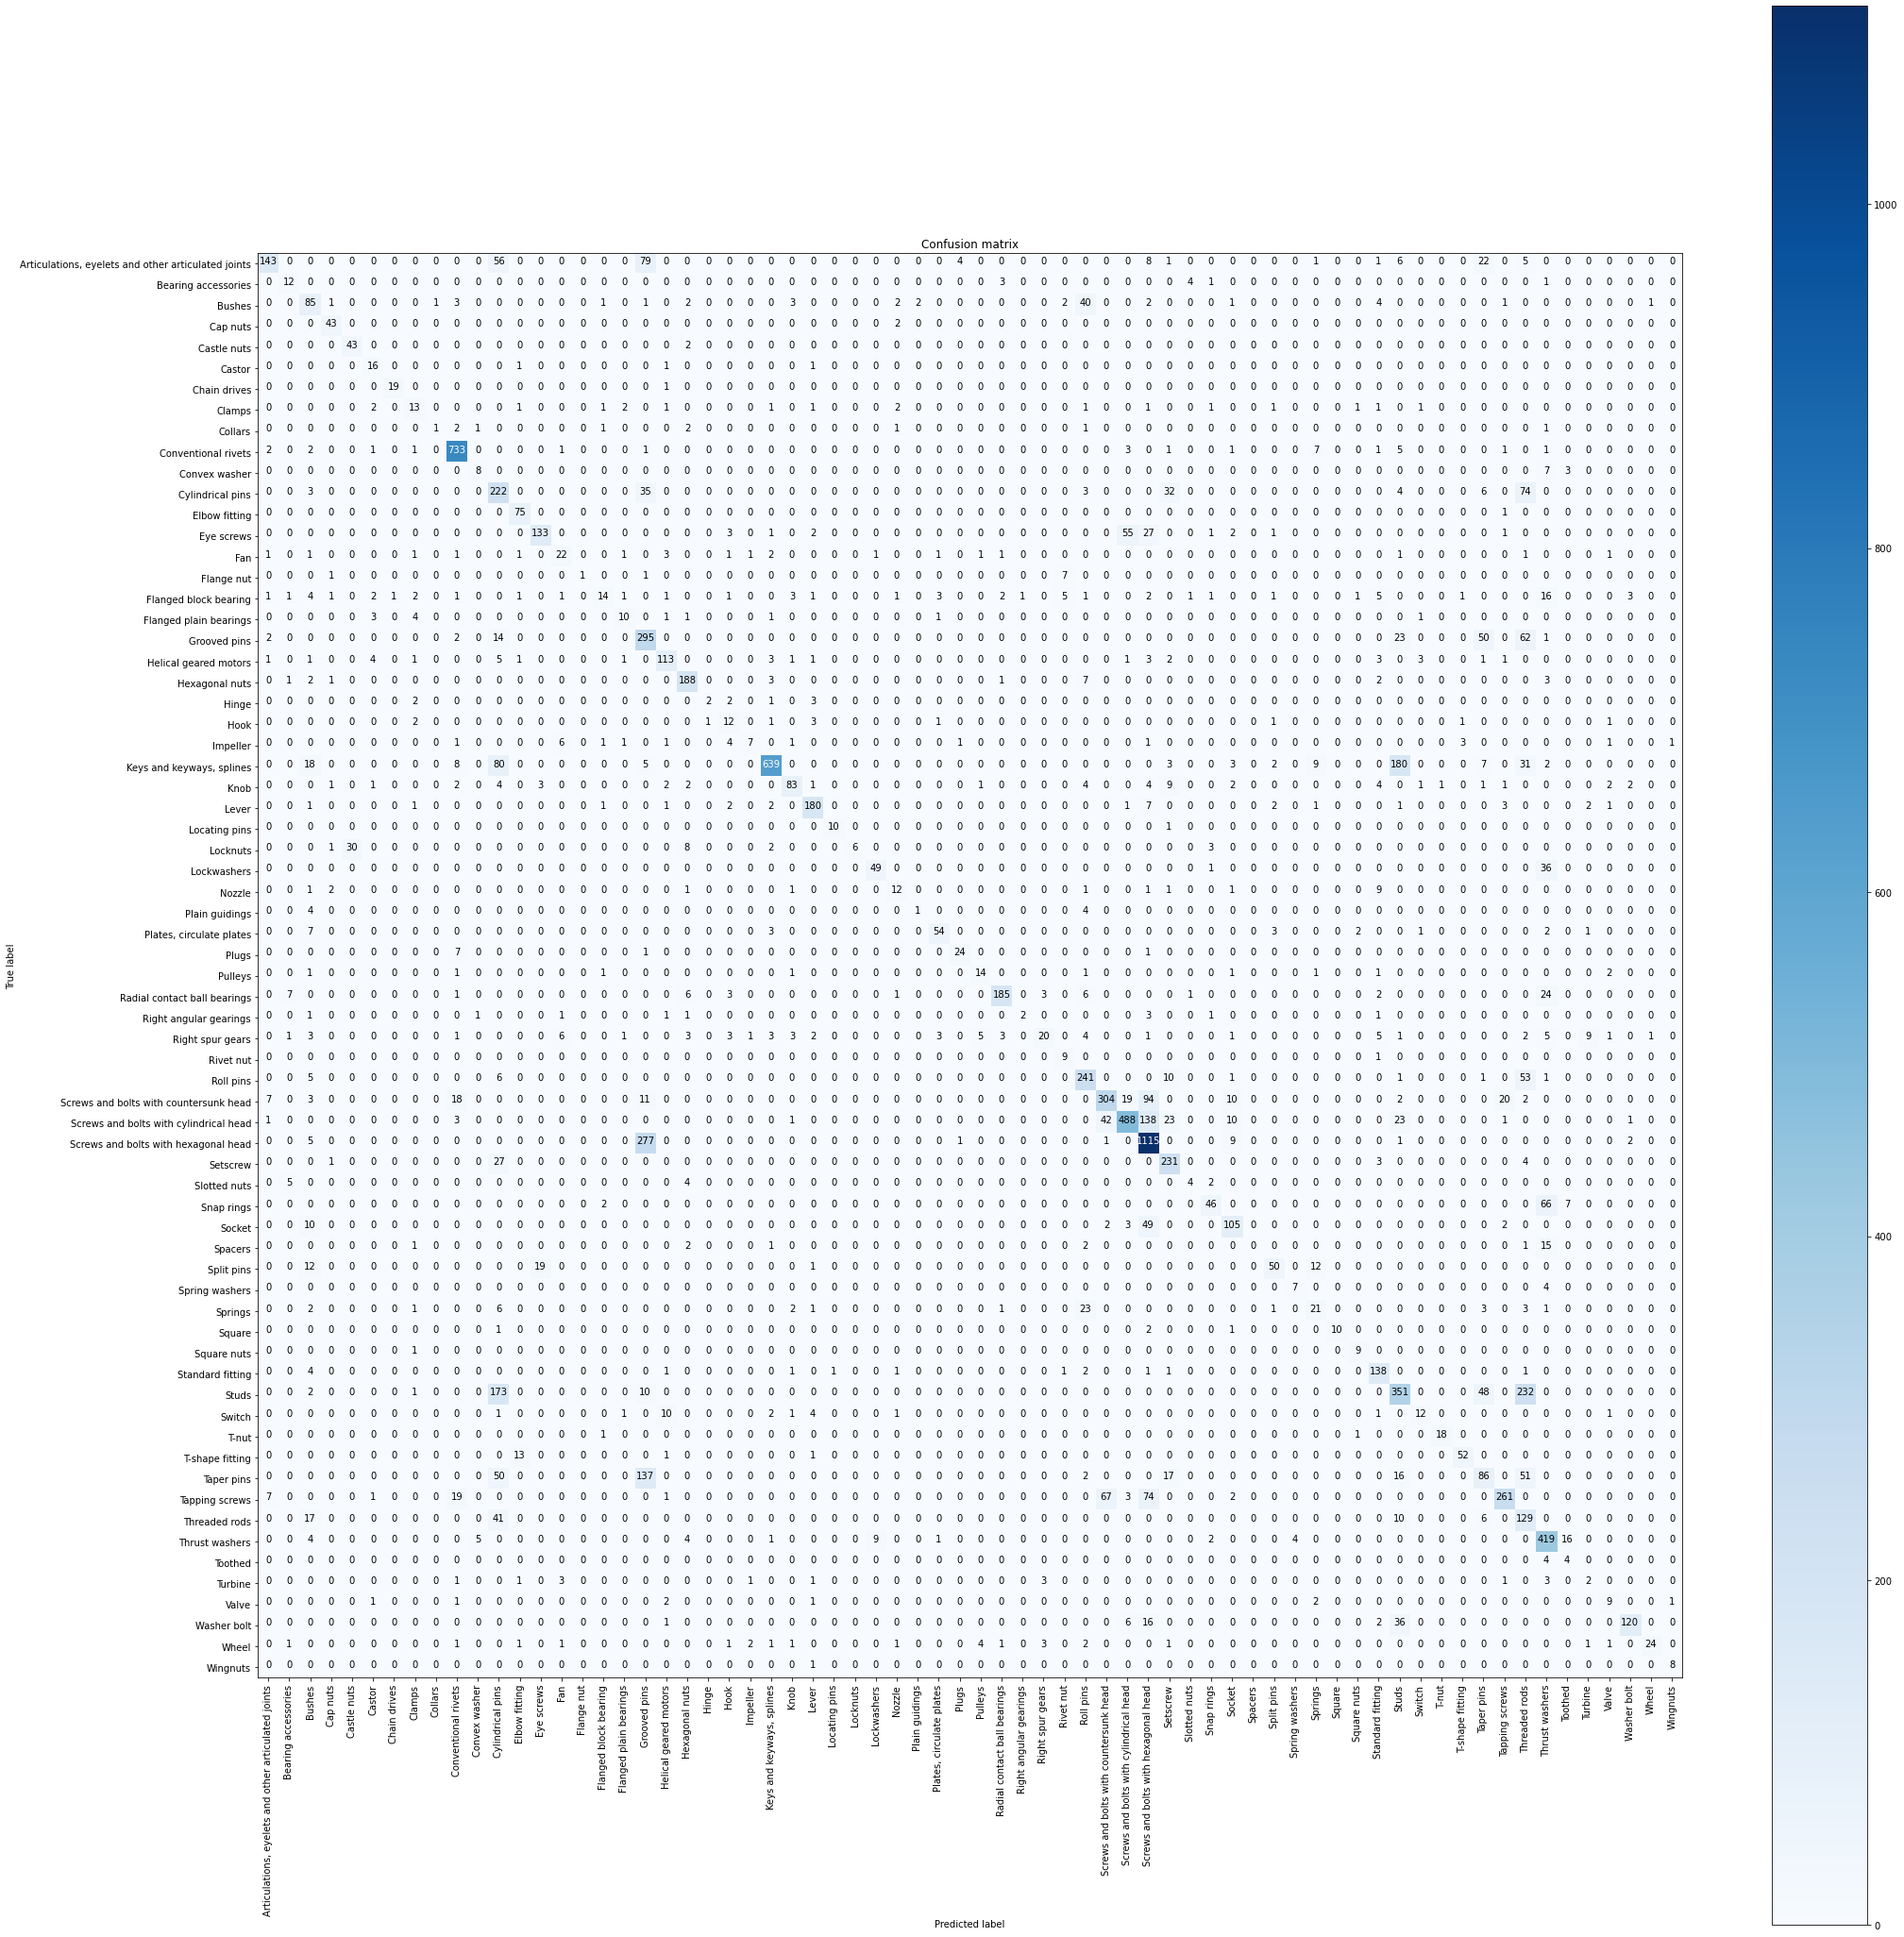

In [47]:
eval_models(model_info)

In [8]:
cm_loaded = np.load("cm_array_pointMLP.npy")
print(len(cm_loaded[0]))
print(cm_loaded[0])

68
[325   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   0   0   0   0   0   0   0]


In [23]:
def confused_analisis(cm): 
    ret = [] 
    for i, confusion in enumerate(cm):
        max_c = 0
        max_c_index = 0 
        summ = np.sum(confusion)
        for j, c in enumerate(confusion):  
            if j != i and c > max_c: 
                max_c = c 
                max_c_index = j
        ret.append((i, inv_classes[i], (confusion[i] / summ), confusion[i], max_c, max_c_index, inv_classes[max_c_index]))
    return ret

In [24]:
stats = confused_analisis(cm_loaded)
print(stats)
# m = confused_analisis(cm_loaded) 
# df_stat = pd.Dataframe(columns=["class_index", "class_name", ])

[(0, 'Articulations, eyelets and other articulated joints', 0.9969325153374233, 325, 1, 60, 'Threaded rods'), (1, 'Bearing accessories', 0.047619047619047616, 1, 19, 44, 'Slotted nuts'), (2, 'Bushes', 0.6644736842105263, 101, 14, 39, 'Roll pins'), (3, 'Cap nuts', 0.8888888888888888, 40, 3, 20, 'Hexagonal nuts'), (4, 'Castle nuts', 1.0, 45, 0, 0, 'Articulations, eyelets and other articulated joints'), (5, 'Castor', 0.0, 0, 8, 14, 'Fan'), (6, 'Chain drives', 0.75, 15, 3, 9, 'Conventional rivets'), (7, 'Clamps', 0.0, 0, 7, 19, 'Helical geared motors'), (8, 'Collars', 0.0, 0, 4, 2, 'Bushes'), (9, 'Conventional rivets', 0.9868593955321945, 751, 2, 37, 'Right spur gears'), (10, 'Convex washer', 0.0, 0, 18, 61, 'Thrust washers'), (11, 'Cylindrical pins', 0.8021108179419525, 304, 28, 58, 'Taper pins'), (12, 'Elbow fitting', 0.9605263157894737, 73, 2, 57, 'T-shape fitting'), (13, 'Eye screws', 0.8938053097345132, 202, 15, 25, 'Knob'), (14, 'Fan', 0.6190476190476191, 26, 6, 19, 'Helical geared m

In [13]:
classes = get_classes(val_annot)
inv_classes = {v : k for k,v in classes.items()}
inv_classes[0]

'Articulations, eyelets and other articulated joints'

In [11]:
print(len(classes)

68


In [58]:
# arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
arr = np.array([200, 0, 0, 1, 4, 2, 2])
index = 0
v = np.where(arr == np.amax(arr) and arr)

array([1])